In [3]:
import pyspark.sql.functions as fn
import pyspark.sql.types
from pyspark.sql import SparkSession
from pyspark.sql.types import *

In [113]:
# 1. Filters years from 2005-2020
# 2. Unbucketize the columns
# 3. Filters chosen countries
def filterCountryData(df,countries_chosen):
    
    # range b/w 2005-2020
    years = list(map(lambda x: str(x),list(range(2005,2021,1)))) 
    
    cols =["Country Name","Country Code","Indicator Name","Indicator Code"]+years
    country_2005_20 = df.select(cols)
    
    
    # filters countries chosen and fills any missing year values with 0.00
    ts = "2020-04-01"
    countries_chosen_2005_20 = (country_2005_20
                                .filter(fn.col("Country Name").isin(countries_chosen)).fillna(0.00, subset=years)
                                .withColumn("date",fn.date_format(fn.lit(ts),"yyyy-MM-dd"))
                               )
    
    #unbucketize the data
    unpivotStr= list(map(lambda x: " '{t}',`{t}`".format(t=x),years))
    sep = ','
    unpivotExpr = "stack("+str(len(years))+", "+sep.join(unpivotStr)+") as (Year, Value)"
    columns_without_years= set(countries_chosen_2005_20.columns ) - set(years)
    
    res = countries_chosen_2005_20.select(
        "Country Name",
        "Country Code",
        "Indicator Name",
        fn.expr(unpivotExpr),
        fn.month("date").alias("month"),
        fn.dayofmonth("date").alias("day"),
        fn.quarter("date").alias("quarter")            
    ).groupBy("Country Name","Year").pivot("Indicator Name").sum("Value")
    
    #TODO: join the dimensions to make a fact table

    return res

In [2]:
# Date Dimension
def generate_dates(spark,range_list,interval=60*60*24,dt_col="date_time_ref"): # TODO: attention to sparkSession
     """
     Create a Spark DataFrame with a single column named dt_col and a range of date within a specified interval (start and stop included).
     With hourly data, dates end at 23 of stop day

     :param spark: SparkSession or sqlContext depending on environment (server vs local)
     :param range_list: array of strings formatted as "2018-01-20" or "2018-01-20 00:00:00"
     :param interval: number of seconds (frequency), output from get_freq()
     :param dt_col: string with date column name. Date column must be TimestampType

     :returns: df from range
     """
     start,stop = range_list
     temp_df = spark.createDataFrame([(start, stop)], ("start", "stop"))
     temp_df = temp_df.select([fn.col(c).cast("timestamp") for c in ("start", "stop")])
     temp_df = temp_df.withColumn("stop",fn.date_add("stop",1).cast("timestamp"))
     temp_df = temp_df.select([fn.col(c).cast("long") for c in ("start", "stop")])
     start, stop = temp_df.first()
     return spark.range(start,stop,interval).select(fn.col("id").cast("timestamp").alias(dt_col))


def dateDimension():
    time_rng = ["2005-01-01","2020-12-31"]
    year_df= generate_dates(spark,time_rng)
    tmp = (year_df
           .withColumn("year",fn.year("date_time_ref"))
           .withColumn("month",fn.month("date_time_ref"))
           .withColumn("day",fn.dayofmonth("date_time_ref"))
           .withColumn("quarter",fn.quarter("date_time_ref"))
           .withColumn("decade",
                          fn.when(fn.col("year") % 10 >=5,fn.col("year")-fn.col("year")%10+10)
                              .otherwise(fn.col("year")- fn.col("year") % 10))
           .withColumn("year_code",fn.monotonically_increasing_id())

          )
    date_dim = (tmp
                   .select(tmp.year_code,*set(tmp.columns)-set(["year_code"]))
               )
    
    return date_dim

In [5]:
def naturalDisasterDim(df,filePath,countries_chosen):
    """
        creates natural disaster dimension + look up table
    
        df - date dataframe
        filePath - filePath to natural disaster csv
        countries_chosen - list of strings of countries to work on
    """
    
    columns = ["total deaths","Total Damages ('000 US$)"]
    
    # reads csv
    natural_disaster_df = (spark
                       .read
                       .format('csv')
                           .option("inferSchema",True)
                           .option("header",True)
                           .load(filePath)
                           .fillna(0.00,subset=columns)).dropDuplicates()
    

    # reconfigures column names + banding
    
    tmp_nd = (natural_disaster_df
                  # replaces United States of America -> united states
              .withColumn("Country",fn.when(fn.lower(fn.col("Country")).contains("united states"),"united states").otherwise(fn.lower(fn.col("Country"))))
              .withColumn("start_month",fn.col("Start Month"))
                  .withColumn("start_year",fn.col("Start Year"))
                  .withColumn("start_day",fn.col("Start Day"))
                  .withColumn("end_month",fn.col("End Month"))
                  .withColumn("end_year",fn.col("End Year"))
                  .withColumn("end_day",fn.col("End Day"))
              .withColumn("disaster_type",fn.col("Disaster Type"))
              .withColumn("disaster_subtype",fn.col("disaster subtype"))
              .withColumn("disaster_nestedsubtype",fn.col("disaster subsubtype"))
              .withColumn("disaster_subgroup",fn.col("disaster subgroup"))
              .withColumn("event_name",fn.col("event name"))
              .withColumn("ofda_response",fn.col("ofda response"))
              .fillna(1.0,["start_day","start_month","start_year","end_day","end_month","end_year"])
              .fillna("Not Available",["disaster_type","disaster_subtype","disaster_nestedsubtype","disaster_subgroup","event_name","ofda_response"])
              .withColumn("ttl_death",
                          # range (low,medium, high)
                          fn.when(fn.col("total deaths")>7000,
                                  fn.when(fn.col("total deaths")>14000,"high").otherwise("medium")).otherwise("low")
                         )
              .withColumn("ttl_damages",
                          # 
                          fn.when(fn.col("Total Damages ('000 US$)")>1000000,
                                  fn.when(fn.col("Total Damages ('000 US$)")>100000000,"high").otherwise("medium")).otherwise("low")
                         )
              
                  .drop("year")
             )

    # join on start year
    
    max_year = df.select(fn.max("year")).limit(1).collect()[0][0]
    min_year = df.select(fn.min("year")).limit(1).collect()[0][0]
    
    nd_j_on_date = tmp_nd.filter(fn.col("start_year")>=min_year).filter(fn.col("end_year")<=max_year)

    # filter countries chosen
    filtered_byCountry_date = (nd_j_on_date
           .filter(fn.col("Country").isin(list(map(lambda x: x.lower(),countries_chosen))))
           
    )
    
    # distinct banded rows with key
    res = (filtered_byCountry_date  
                                  .select([
                                           "disaster_type",
                                           "disaster_subtype",
                                           "disaster_nestedsubtype",
                                           "disaster_subgroup",
                                           "event_name",
                                           "ttl_death",
                                           "ttl_damages",
                                           "ofda_response"])                                   
                                 ).distinct().withColumn("natural_disaster_key",fn.monotonically_increasing_id())
    
    
    lookup=(res.join(
        filtered_byCountry_date,
        on = [
            "disaster_type","disaster_subtype","disaster_nestedsubtype","disaster_subgroup","event_name","ofda_response","ttl_damages","ttl_death"
        ])
        .select("natural_disaster_key","Country","start_year","start_month","start_day","end_year","end_month","end_day")
        )
    
    
    # dimension, lookup
    return res,lookup



In [88]:
def countryDimension(time_df,indicators,countries_chosen,filePath):
    max_year = time_df.select(fn.max("year")).limit(1).collect()[0][0]
    min_year = time_df.select(fn.min("year")).limit(1).collect()[0][0]
    
    countries = (spark
                       .read
                       .format('csv')
                           .option("inferSchema",True)
                           .option("header",True)
                           .load(filePath)
                        )

    indicators = (indicators
                  .withColumn("country_name",fn.lower("Country Name"))
                  .drop("Country Name")
                  .withColumn("age_dependency_ratio_workingage",
                              fn.when(fn.col("Age dependency ratio (% of working-age population)")>100.00, 100.00)
                              .otherwise(fn.col("Age dependency ratio (% of working-age population)")),)
                  .withColumn("labor_force_total",
                              fn.when(fn.col("Labor force, total")>30000000,
                                     fn.when(fn.col("Labor force, total")>80000000,"high").otherwise("medium")
                                     ).otherwise("low"))
                  .select(
                      fn.col("country_name"),
                      fn.col("Population, total").alias("population_total"),
                      fn.col("Population growth (annual %)").alias("population_growth"),
                      fn.col("Urban population growth (annual %)").alias("urban_population_growth"),
                      fn.col("Urban population").alias("urban_population"),
                      fn.col("Rural population").alias("rural_population"),
                      fn.col("Unemployment, total (% of total labor force)").alias("unemployment_rate"),
                      fn.col("age_dependency_ratio_workingage"),
                      fn.col("Poverty headcount ratio at national poverty line (% of population)").alias("poverty_headcount_percentage"),
                      fn.col("labor_force_total"),
                      fn.col("Net migration").alias("net_migration"),
                      fn.col("year")
                  )
#                   .fillna(
#                       indicators.select(fn.avg("Age dependency ratio (% of working-age population)")).collect()[0][0],
#                       subset=["age_dependency_ratio_workingage"]
#                   )
                 )
    tmp = (countries
               .filter(fn.lower(fn.col("short name")).isin(list(map(lambda x: x.lower(),countries_chosen))))
               .select(
                   fn.lower("Currency Unit").alias("currency"),
                   fn.lower("short name").alias("country_name"),
                   fn.col("region"),
               )
          )
    
    res = (tmp.join(indicators,on=["country_name"]).withColumn("country_key",fn.monotonically_increasing_id()))
    
    lookup = (res.select(
        "country_name",
        "year",
        "country_key"
    ))

           
    return res.drop("year"), lookup
               
dateDim = dateDimension()
df,tmp = countryDimension(  
    dateDim,
    filterdCountryDf,
    countries_chosen=countries_chosen,
    filePath="AssignmentData/HNP_StatsCountry.csv")

display(df.toPandas())
display(tmp.toPandas())

,country_name,currency,region,population_total,population_growth,urban_population_growth,urban_population,rural_population,unemployment_rate,age_dependency_ratio_workingage,poverty_headcount_percentage,labor_force_total,net_migration,country_key
0,nigeria,nigerian naira,Sub-Saharan Africa,176404931.0,2.665007,4.521129,82878565.0,93526366.0,4.56,88.498487,0.0,medium,0.0,0
1,somalia,somali shilling,Sub-Saharan Africa,13423571.0,2.717396,4.042955,5729046.0,7694525.0,13.32,100.000000,0.0,low,0.0,1
2,finland,euro,Europe & Central Asia,5313399.0,0.465549,0.622925,4426008.0,887391.0,6.37,50.079271,13.8,low,0.0,17179869184
3,mexico,mexican peso,Latin America & Caribbean,121858251.0,1.241165,1.610136,96615314.0,25242937.0,4.31,52.347721,0.0,medium,0.0,34359738368
4,thailand,thai baht,East Asia & Pacific,68971313.0,0.373015,1.941560,33415222.0,35556091.0,0.69,40.157546,8.6,medium,0.0,51539607552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,canada,canadian dollar,North America,35702908.0,0.746339,0.796808,29011826.0,6691082.0,6.91,47.156456,0.0,low,0.0,1666447310848
140,norway,norwegian krone,Europe & Central Asia,5379475.0,0.588757,1.021155,4463566.0,915909.0,4.62,53.335836,0.0,low,0.0,1666447310849
141,mexico,mexican peso,Latin America & Caribbean,107560155.0,1.456213,1.859028,82408288.0,25151867.0,3.57,59.071730,0.0,medium,0.0,1675037245440
142,somalia,somali shilling,Sub-Saharan Africa,10763904.0,2.989724,5.139336,3993408.0,6770496.0,13.19,100.000000,0.0,low,0.0,1675037245441


,country_name,year,country_key
0,nigeria,2014,0
1,somalia,2014,1
2,finland,2008,17179869184
3,mexico,2015,34359738368
4,thailand,2016,51539607552
...,...,...,...
139,canada,2015,1666447310848
140,norway,2020,1666447310849
141,mexico,2006,1675037245440
142,somalia,2006,1675037245441


In [6]:
spark = SparkSession.builder.appName("ds_datastage").getOrCreate()

In [ ]:
#MAIN block
countries_chosen = ["United States", "Canada","Mexico","Thailand","China","India","Niger","Madagascar","Guinea"]

df=spark.read.format("csv").option("header",True).option("inferSchema",True).load("AssignmentData/HNP_StatsData.csv")

#filtered data
filterdCountryDf=filterCountryData(df,countries_chosen)

# dateDim = dateDimension()
# naturalDisasterDimension, nd_lookup=naturalDisasterDim(
#     dateDim,
#     countries_chosen=countries_chosen,
#     filePath="AssignmentData/ExternalSources/DISASTERS/1900_2021_DISASTERS.xlsx - emdat data.csv"
# )
# countryDimension = 
# display(naturalDisasterDimension.toPandas())
# display(nd_lookup.toPandas())
display(filterdCountryDf.toPandas())
# display(dateDim.toPandas())
filterdCountryDf.count()

C:\Users\aweso\venv\lib\site-packages\pyspark\sql\pandas\conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
C:\Users\aweso\venv\lib\site-packages\pyspark\sql\pandas\conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
C:\Users\aweso\venv\lib\site-packages\pyspark\sql\pandas\conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining 

C:\Users\aweso\venv\lib\site-packages\pyspark\sql\pandas\conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
C:\Users\aweso\venv\lib\site-packages\pyspark\sql\pandas\conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
C:\Users\aweso\venv\lib\site-packages\pyspark\sql\pandas\conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining 

C:\Users\aweso\venv\lib\site-packages\pyspark\sql\pandas\conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
C:\Users\aweso\venv\lib\site-packages\pyspark\sql\pandas\conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
C:\Users\aweso\venv\lib\site-packages\pyspark\sql\pandas\conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining 

In [48]:

### TESTING BLOCK


# ## LOOKUP TABLE LOGIC
# # 2006-2010
# tmp = dateDim.filter(fn.col("year")==2006).select(fn.col("year").alias("year_2"))
# dateDim_a = dateDim.alias("a")
# tmp_b = tmp.alias("b")

# test2 = dateDim_a.join(tmp_b.alias("b"),tmp_b.year_2<dateDim_a.year)
# test3 = dateDim_a.join(tmp_b.alias("b"),2010>dateDim_a.year)

# test2.show()
# test3.show()

# test3.intersect(test2).show()


AttributeError: 'SparkSession' object has no attribute 'parallelize'

In [66]:
### TEST FUNCTIONS

import matplotlib.pyplot as plt 
import numpy as np

# df - dataframe
# col - column to observe
def nullCount(df,cl):
    non_null =(df
     .filter(fn.col(cl).isNotNull())
    )
    
    
    null = (df
        .filter(fn.col(cl).isNull()))
    
    print("Number of non null values: "+str(non_null.count()))
    print("Number of null values: "+str(null.count()))
    
    
def summary_df(df,cl,bns = 10):
    """
        returns null counts, basic statistics & plot of current values in a column
        
        df - dataframe you wish to observer these statistics
        cl - column of which you wish to observe
        bns - bins (number of bars) histogram will try to bucketize data in
    """
    nullCount(df,cl)
    
#     df.groupBy(fn.col(cl)).count().orderBy(fn.asc(fn.col(cl))).show()
#     df.groupBy(fn.col(cl)).count().orderBy(fn.desc(fn.col(cl))).show()
    
    tmp = df.filter(fn.col(cl).isNotNull())
    tmp.select(cl).describe().show()

    pd_data = tmp.select(fn.col(cl)).toPandas()
    # display(pd_data)
    plt.hist(pd_data,bins = bns)
    plt.title("Histogram of " +str(cl))
    plt.xlabel(cl)
    plt.ylabel("count")

Number of non null values: 144
Number of null values: 0
+-------+-----------------+
|summary|    net_migration|
+-------+-----------------+
|  count|              144|
|   mean|        126218.75|
| stddev|751809.8149525118|
|    min|        -562404.0|
|    max|        5428756.0|
+-------+-----------------+



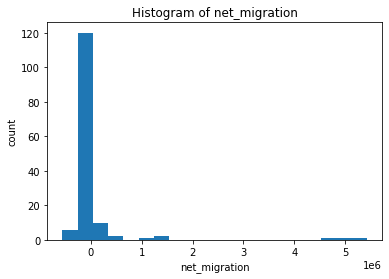

In [80]:
#"Total Damages ('000 US$)"
summary_df(tmp,"net_migration",bns=20)

In [104]:
filterdCountryDf.columns

['Country Name',
 'Year',
 'AIDS estimated deaths (UNAIDS estimates)',
 'ARI treatment (% of children under 5 taken to a health provider)',
 'Adolescent fertility rate (births per 1,000 women ages 15-19)',
 'Adults (ages 15+) and children (0-14 years) living with HIV',
 'Adults (ages 15+) and children (ages 0-14) newly infected with HIV',
 'Adults (ages 15+) living with HIV',
 'Adults (ages 15-49) newly infected with HIV',
 'Age at first marriage, female',
 'Age at first marriage, male',
 'Age dependency ratio (% of working-age population)',
 'Age dependency ratio, old',
 'Age dependency ratio, young',
 'Age population, age 00, female, interpolated',
 'Age population, age 00, male, interpolated',
 'Age population, age 01, female, interpolated',
 'Age population, age 01, male, interpolated',
 'Age population, age 02, female, interpolated',
 'Age population, age 02, male, interpolated',
 'Age population, age 03, female, interpolated',
 'Age population, age 03, male, interpolated',
 'Age 

In [109]:
cl = 'Primary completion rate, total (% of relevant age group)'
first = filterdCountryDf.filter(fn.col(cl).isNotNull()).groupBy("Country Name").agg(fn.count("*").alias("nonnull"))
second = filterdCountryDf.filter(fn.col(cl).isNull()).groupBy("Country Name").agg(fn.count("*").alias("null"))

In [112]:
second.join(first,["Country Name"],'right').withColumn("ratio",fn.col("nonnull")/fn.col("null")).orderBy(fn.desc("ratio")).show(300,False)

+-------------+----+-------+-----+
|Country Name |null|nonnull|ratio|
+-------------+----+-------+-----+
|Canada       |null|16     |null |
|Thailand     |null|16     |null |
|Mexico       |null|16     |null |
|Madagascar   |null|16     |null |
|Guinea       |null|16     |null |
|India        |null|16     |null |
|China        |null|16     |null |
|United States|null|16     |null |
|Niger        |null|16     |null |
+-------------+----+-------+-----+

